<a href="https://colab.research.google.com/github/tylee33/DLforFinance/blob/master/Black_Letterman_Portfolio_Optimization_with_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [0]:
# Equilibrium Portfolio Weights
# p.16 Appendix A Table 1
# AUL, CAN, FRA, GER, JAP, UKG, USA
w = np.array([[0.016, 0.022, 0.052, 0.055, 0.116, 0.124, 0.615]]).T

In [0]:
# Correlation Matrix
# p.16 Appendix A Table 2
# AUL, CAN, FRA, GER, JAP, UKG, USA
correlation = np.array([
        [1, 0.488, 0.478, 0.515, 0.439, 0.512, 0.491],
        [0.488, 1, 0.664, 0.655, 0.310, 0.608, 0.779],
        [0.478, 0.664, 1, 0.861, 0.355, 0.783, 0.668],
        [0.515, 0.655, 0.861, 1, 0.354, 0.777, 0.653],
        [0.439, 0.310, 0.355, 0.354, 1, 0.405, 0.306],
        [0.512, 0.608, 0.783, 0.777, 0.405, 1, 0.652],
        [0.491, 0.779, 0.668, 0.653, 0.306, 0.652, 1]])

In [0]:
# Standard Deviation (Volatility)
# p.16 Appendix A Table 2
# AUL, CAN, FRA, GER, JAP, UKG, USA
std = np.array([[0.16, 0.203, 0.248, 0.271, 0.21, 0.2, 0.187]])

In [0]:
# Variance Covariance Matrix (which can be calculated with the correlation and volatility above)
Sigma = correlation * np.dot(std.T, std)

In [0]:
# delta (δ): risk aversion parameter (scalar)
# p.4 footnote
delta = 2.5

In [0]:
# tau (τ): a scalar measures the uncertainty of the CAPM prior
tau = 0.05

In [0]:
### (1) Reverse Optimization
### Inputs: Equilibrium Portfolio Weights, Standard Deviation (Volatility)
### Output: Equilibrium Expected Returns (p.16 Appendix A Table 1)
#
# U: the utility function of the optimization - w which maximizes U is a set of weights for the optimized portfolio
# U= wTΠ − δ/2wTΣw
#
# When w maximizing U, the following equation must hold:
# dU/dw = Π − δΣw = 0
# Π = δΣw
#
# Π: Equilibrium Expected Returns (nx1 vector) (p.16 Appendix A Table 1) —> r_eq
# Π′: Black-Litterman expected returns updated by an investor’s view (nx1 vector) (p.7 Chart 2A) —> r_posterior
# w: Equilibrium Portfolio Weights (nx1 vector) (p.16 Appendix A Table 1)
# w′: Optimal Portfolio Weights (nx1 vector) (p.9 Chart 3B)
# Σ: Variance Covariance Matrix
# P, Q: Investor’s view matrix
# Ω: Investor’s view confidence matrix
# delta (δ): investor’s risk aversion parameter (scalar)
# tau (τ): a scalar measures the uncertainty of the CAPM prior, variance-covariance matrix
#
# reverse optimization
r_eq = delta * np.dot(Sigma, w)
# >>> r_eq
#array([[ 0.03937555],
#       [ 0.0691519 ],
#       [ 0.08358087],
#       [ 0.0902724 ],
#       [ 0.0430281 ],
#       [ 0.06767693],
#       [ 0.07560047]])

In [0]:
### (2) Blending Equilibrium Portfolio Weights with Investor’s Views
### Inputs: Π Equilibrium Expected Returns, P & Q Investor’s view matrix
### Output: Π′ Black-Litterman expected returns updated by an investor’s view —> r_posterior, Σ′ —> Sigma_posterior
#
# Investor’s View
# AUL, CAN, FRA, GER, JAP, UKG, USA
#
# P = [0 0 -0.295 1 0 -0.705 0
#        0 1   0        0 0  0        -1]
# In the first row,
# -0.295: FRA
# 1:GER
# -0.705: UKG
# In the second row,
# 1: CAN
# -1: USA
#
# Q = [ 0.05
#          0.03]
#
# These mean that:
# GER outperforms FRA and UKG by 5%
# CAN outperforms USA by 3%
#
#
# Ω: Investor’s view confidence matrix
# Ω = [ 0.001065 0
#          0              0.000852 ]

P = np.array([
        [0,0,-0.295,1,0,-0.705,0],
        [0,1,0,0,0,0,-1]]) # 2x7 matrix (2: number of views, 7: number of assets)
Q = np.array([[0.05],[0.03]]) # 2-vector
Omega = np.array([
        [0.001065383332,0],
        [0,0.0008517381]])

In [0]:
# Black-Litterman master equation
# Π′ = Π + τΣPT (PτΣPT + Ω)-1 (Q−PΠ)
#
# Blending Investor’s View with the Equilibrium Returns
r_posterior = r_eq + np.dot( np.dot( tau*np.dot(Sigma,P.T), np.linalg.inv(tau*np.dot(np.dot(P,Sigma),P.T)+Omega)), (Q-np.dot(P,r_eq)))
#
# AUL, CAN, FRA, GER, JAP, UKG, USA
#
# >>> r_posterior
#array([[ 0.04422145],
#       [ 0.08729864],
#       [ 0.09479745],
#       [ 0.11209947],
#       [ 0.04616347],
#       [ 0.0697166 ],
#       [ 0.0748156 ]])
#
#
# On top of the returns, variance-covariance matrix can be updated as follows:
# Σ′ = Σ + τΣ -τΣPT (PτΣPT + Ω)-1PτΣ
Sigma_posterior = Sigma + tau*Sigma - tau*np.dot( np.dot( np.dot(Sigma,P.T), np.linalg.inv(tau*np.dot(np.dot(P,Sigma),P.T)+Omega)), tau*np.dot(P,Sigma))
#
#>>> Sigma_posterior
#array([[ 0.02684723,  0.01657429,  0.0198378 ,  0.02328236,  0.01547005,
#         0.01718801,  0.01539182],
#       [ 0.01657429,  0.04299381,  0.03494199,  0.03753285,  0.01383059,
#         0.02589072,  0.03107504],
#       [ 0.0198378 ,  0.03494199,  0.06439533,  0.06036839,  0.01937078,
#         0.04074256,  0.03244592],
#       [ 0.02328236,  0.03753285,  0.06036839,  0.07627367,  0.02106627,
#         0.04414171,  0.03454918],
#       [ 0.01547005,  0.01383059,  0.01937078,  0.02106627,  0.04629476,
#         0.01785243,  0.01260504],
#       [ 0.01718801,  0.02589072,  0.04074256,  0.04414171,  0.01785243,
#         0.04199287,  0.0255861 ],
#       [ 0.01539182,  0.03107504,  0.03244592,  0.03454918,  0.01260504,
#         0.0255861 ,  0.03661572]])

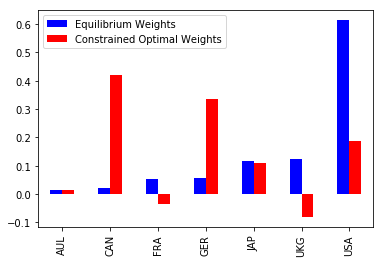

In [11]:
### (3) Optimization - finding optimal weights
### Inputs: Π′, Σ′
### Output: w′ Optimal Portfolio Weights —> w_posterior
#
# w′ = Π′ (δΣ′)-1
#
# Forward Optimization and finding optimal weghts
w_posterior = np.dot(np.linalg.inv(delta*Sigma_posterior), r_posterior)
#
# AUL, CAN, FRA, GER, JAP, UKG, USA
# >>> w_posterior
#array([[ 0.0152381 ],
#       [ 0.41863571],
#       [-0.03409321],
#       [ 0.33582847],
#       [ 0.11047619],
#       [-0.08173526],
#       [ 0.18803095]])
#
# Plot w′ by using pandas
df = pd.DataFrame([w.reshape(7),w_posterior.reshape(7)],
                  columns=['AUL','CAN','FRA','GER','JAP','UKG','USA'],
                  index=['Equilibrium Weights','Constrained Optimal Weights'])
df.T.plot(kind='bar', color='br')